In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
plt.style.use('./deeplearning.mplstyle')
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from lab_utils_common import dlc
from lab_coffee_utils import load_coffee_data, plt_roast, plt_prob, plt_layer, plt_network, plt_output_unit
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
tf.autograph.set_verbosity(0)

In [4]:
X,Y = load_coffee_data();
print(X.shape, Y.shape)

(200, 2) (200, 1)


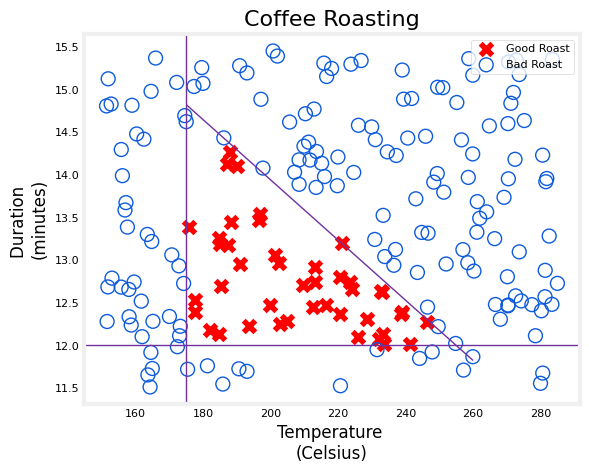

In [5]:
plt_roast(X,Y)

In [6]:
print(f"Temperature Max, Min pre normalization: {np.max(X[:,0]):0.2f}, {np.min(X[:,0]):0.2f}")
print(f"Duration    Max, Min pre normalization: {np.max(X[:,1]):0.2f}, {np.min(X[:,1]):0.2f}")
normalization_layer = tf.keras.layers.Normalization(axis=-1)
normalization_layer.adapt(X)  # learns mean, variance
Xn = normalization_layer(X)
print(f"Temperature Max, Min post normalization: {np.max(Xn[:,0]):0.2f}, {np.min(Xn[:,0]):0.2f}")
print(f"Duration    Max, Min post normalization: {np.max(Xn[:,1]):0.2f}, {np.min(Xn[:,1]):0.2f}")

Temperature Max, Min pre normalization: 284.99, 151.32
Duration    Max, Min pre normalization: 15.45, 11.51
Temperature Max, Min post normalization: 1.66, -1.69
Duration    Max, Min post normalization: 1.79, -1.70


In [7]:
Xt = np.tile(Xn,(1000,1))
Yt= np.tile(Y,(1000,1))
print(Xt.shape, Yt.shape)

(200000, 2) (200000, 1)


**Model**

In [8]:
tf.random.set_seed(1234)
model = Sequential(
    [
        tf.keras.Input(shape=(2,)),
        Dense(3,activation='sigmoid',name='layer1'),
        Dense(1,activation='sigmoid',name='layer2')
    ]
)

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, 3)                 9         
                                                                 
 layer2 (Dense)              (None, 1)                 4         
                                                                 
Total params: 13
Trainable params: 13
Non-trainable params: 0
_________________________________________________________________


In [10]:
L1_num_params = 2 * 3 + 3   # W1 parameters  + b1 parameters
L2_num_params = 3 * 1 + 1   # W2 parameters  + b2 parameters
print("L1 params = ", L1_num_params, ", L2 params = ", L2_num_params  )

L1 params =  9 , L2 params =  4


Let's examine the weights and biases Tensorflow has instantiated. The weights  𝑊
  should be of size (number of features in input, number of units in the layer) while the bias  𝑏
  size should match the number of units in the layer:


1.   In the first layer with 3 units, we expect W to have a size of (2,3) and  𝑏
  should have 3 elements.
2.   In the second layer with 1 unit, we expect W to have a size of (3,1) and  𝑏
  should have 1 element.

In [11]:
W1, b1 = model.get_layer("layer1").get_weights()
W2, b2 = model.get_layer("layer2").get_weights()
print(f"W1{W1.shape}:\n", W1, f"\nb1{b1.shape}:", b1)
print(f"W2{W2.shape}:\n", W2, f"\nb2{b2.shape}:", b2)

W1(2, 3):
 [[-0.29  0.14  0.48]
 [ 0.71  0.27 -0.44]] 
b1(3,): [0. 0. 0.]
W2(3, 1):
 [[0.91]
 [0.93]
 [1.04]] 
b2(1,): [0.]






*   The model.compile statement defines a loss function and specifies a compile optimization.
*   The model.fit statement runs gradient descent and fits the weights to the data.



In [12]:
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01),
)

model.fit(
    Xt,Yt,
    epochs=10,
)

Epoch 1/10
6250/6250 [==============================] - 14s 2ms/step - loss: 0.2123
Epoch 2/10
6250/6250 [==============================] - 10s 2ms/step - loss: 0.1186
Epoch 3/10
6250/6250 [==============================] - 11s 2ms/step - loss: 0.0746
Epoch 4/10
6250/6250 [==============================] - 11s 2ms/step - loss: 0.0194
Epoch 5/10
6250/6250 [==============================] - 11s 2ms/step - loss: 0.0114
Epoch 6/10
6250/6250 [==============================] - 11s 2ms/step - loss: 0.0077
Epoch 7/10
6250/6250 [==============================] - 13s 2ms/step - loss: 0.0053
Epoch 8/10
6250/6250 [==============================] - 12s 2ms/step - loss: 0.0037
Epoch 9/10
6250/6250 [==============================] - 13s 2ms/step - loss: 0.0026
Epoch 10/10
6250/6250 [==============================] - 11s 2ms/step - loss: 0.0018


**Updated Weights**

In [13]:
W1, b1 = model.get_layer("layer1").get_weights()
W2, b2 = model.get_layer("layer2").get_weights()
print("W1:\n", W1, "\nb1:", b1)
print("W2:\n", W2, "\nb2:", b2)

W1:
 [[ 14.68 -11.02   0.17]
 [ 12.18  -0.3   10.26]] 
b1: [  1.99 -11.85  12.39]
W2:
 [[-45.18]
 [-52.85]
 [ 43.24]] 
b2: [-13.53]


**Predictions**

In [14]:
X_test = np.array([
    [200,13.9],  # postive example
    [200,17]])   # negative example
X_testn = normalization_layer(X_test)
predictions = model.predict(X_testn)
print("predictions = \n", predictions)

1/1 [==============================] - 0s 209ms/step
predictions = 
 [[9.92e-01]
 [1.87e-07]]


Now, we apply a threshold to convert these probabilities to predictions

In [15]:
yhat = np.zeros_like(predictions)
for i in range(len(predictions)):
    if predictions[i] >= 0.5:
        yhat[i] = 1
    else:
        yhat[i] = 0
print(f"decisions = \n{yhat}")

decisions = 
[[1.]
 [0.]]


In [16]:
yhat = (predictions >= 0.5).astype(int)
print(f"decisions = \n{yhat}")

decisions = 
[[1]
 [0]]


**Layer Functions**

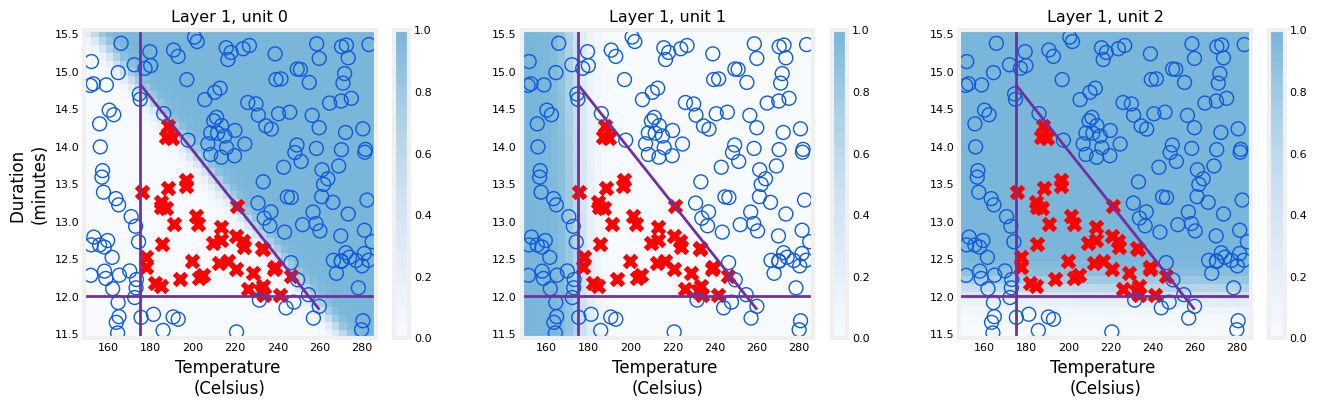

In [18]:
plt_layer(X,Y.reshape(-1,),W1,b1,normalization_layer)

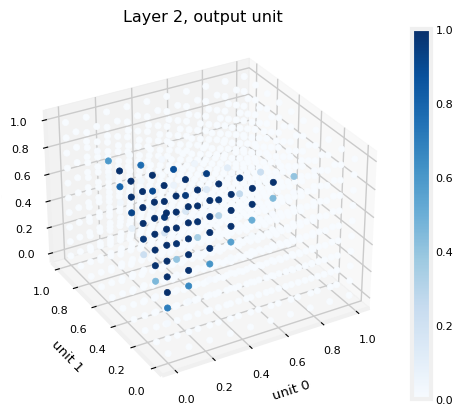

In [19]:
plt_output_unit(W2,b2)